# Credit Scoring Business Application

## A Classification Model to deploy with SAS Model Manager and SAS Workflow Manager

In this notebook, 

1. I train classification models based on Mondodb nosql data
2. I build Machine Learning pipeline to scoring data in production
3. I create the model package to deploy the model via SAS Scoring Container

## Data
After analyzing the data, the company selected a subset of 12 predictor (or input)
variables to model whether each applicant defaulted. The response (or target) variable
(BAD) indicates whether an applicant defaulted on the home equity line of credit.
These variables, along with their model role, measurement level, and description, are
shown in the following table from the **HMEQ** data set.

| Name      | Model Role | Measurement Level | Description                                                            |
|:----------|:-----------|:------------------|:-----------------------------------------------------------------------|
| BAD       | Target     | Binary            | 1 = applicant defaulted on loan or delinquent, 0 = applicant paid loan |
| CLAGE     | Input      | Interval          | Age of oldest credit line in months                                    |
| CLNO      | Input      | Interval          | Number of credit lines                                                 |
| DEBTINC   | Input      | Interval          | Debt-to-income ratio                                                   |
| DELINQ    | Input      | Interval          | Number of delinquent credit lines                                      |
| DEROG     | Input      | Interval          | Number of derogatory reports                                           |
| JOB       | Input      | Nominal           | Occupational categories                                                |
| LOAN      | Input      | Interval          | Amount of loan request                                                 |
| MORTDUE   | Input      | Interval          | Amount due on existing mortgage                                        |
| NINQ      | Input      | Interval          | Number of recent credit inquiries                                      |
| REASON    | Input      | Binary            | DebtCon = debt consolidation, HomeImp = home improvement               |
| VALUE     | Input      | Interval          | Value of current property                                              |
| YOJ       | Input      | Interval          | Years at present job                                                   |

## Libraries

In [1]:
# Mongo Library

import pymongo

# ML libraries 

import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.base import TransformerMixin
import sklearn.metrics as metrics
import sklearn.model_selection as model_selection
import statsmodels.api as smodel
from xgboost import XGBClassifier 

# Tool libraries

# import json
import os
import pprint
import json
# import requests as req
# import random
# import pickle
import zipfile
# import urllib
# import base64
# import time
# import sys

# import sasctl

## Data Engineering

### Load Data from Mongo

In [2]:
#Connect to mongodb container

conn = pymongo.MongoClient('mongo', 27017)

In [3]:
conn

MongoClient(host=['mongo:27017'], document_class=dict, tz_aware=False, connect=True)

In [4]:
db = conn.training
collection = db.churn_data

In [5]:
df = pd.DataFrame(list(collection.find()))
df.drop('_id', axis=1, inplace=True)
df.drop_duplicates(inplace=True)
df.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860,39025,HomeImp,Other,10.5,0,0,94.3667,1,9,
1,1,1300,70053,68400,HomeImp,Other,7,0,2,121.833,0,14,
2,1,1500,13500,16700,HomeImp,Other,4,0,0,149.467,1,10,
3,1,1500,,,,,,,,,,,
4,0,1700,97800,112000,HomeImp,Office,3,0,0,93.3333,0,14,


### Declare data types

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5960 entries, 0 to 5959
Data columns (total 13 columns):
BAD        5960 non-null int64
LOAN       5960 non-null int64
MORTDUE    5960 non-null object
VALUE      5960 non-null object
REASON     5960 non-null object
JOB        5960 non-null object
YOJ        5960 non-null object
DEROG      5960 non-null object
DELINQ     5960 non-null object
CLAGE      5960 non-null object
NINQ       5960 non-null object
CLNO       5960 non-null object
DEBTINC    5960 non-null object
dtypes: int64(2), object(11)
memory usage: 651.9+ KB


In [7]:
cols = df[df.columns.difference(['BAD','LOAN','REASON','JOB'])].columns
df[cols] = df[cols].apply(pd.to_numeric, downcast='float', errors='coerce')
df['BAD']=df['BAD'].astype('category')

In [8]:
df.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366669,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833336,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466660,1.0,10.0,NaN
3,1,1500,NaN,NaN,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333336,0.0,14.0,NaN


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5960 entries, 0 to 5959
Data columns (total 13 columns):
BAD        5960 non-null category
LOAN       5960 non-null int64
MORTDUE    5442 non-null float32
VALUE      5848 non-null float32
REASON     5960 non-null object
JOB        5960 non-null object
YOJ        5445 non-null float32
DEROG      5252 non-null float32
DELINQ     5380 non-null float32
CLAGE      5652 non-null float32
NINQ       5450 non-null float32
CLNO       5738 non-null float32
DEBTINC    4693 non-null float32
dtypes: category(1), float32(9), int64(1), object(2)
memory usage: 401.7+ KB


### Declare variables 

In [10]:
#target var
target = df.select_dtypes('category').columns

#categorical (nominal and ordinal) variables
class_inputs = list(df.select_dtypes('object').columns)

#input interval variables
numerical_inputs = list(df.select_dtypes(include=['int64', 'float32']).columns)

inputs= class_inputs + numerical_inputs

print(target)
print(class_inputs)
print(numerical_inputs)
print(inputs)

Index(['BAD'], dtype='object')
['REASON', 'JOB']
['LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC']
['REASON', 'JOB', 'LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC']


In [11]:
df[inputs]

,REASON,JOB,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,HomeImp,Other,1100,25860.0,39025.0,10.5,0.0,0.0,94.366669,1.0,9.0,NaN
1,HomeImp,Other,1300,70053.0,68400.0,7.0,0.0,2.0,121.833336,0.0,14.0,NaN
2,HomeImp,Other,1500,13500.0,16700.0,4.0,0.0,0.0,149.466660,1.0,10.0,NaN
3,,,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,HomeImp,Office,1700,97800.0,112000.0,3.0,0.0,0.0,93.333336,0.0,14.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
5955,DebtCon,Other,89000,54576.0,92937.0,16.0,0.0,0.0,208.692062,0.0,15.0,35.859970
5956,DebtCon,Other,89200,54045.0,92924.0,15.0,0.0,0.0,212.279694,0.0,15.0,35.556591
5957,DebtCon,Other,89800,50370.0,91861.0,14.0,0.0,0.0,213.892715,0.0,16.0,34.340881
5958,DebtCon,Other,89900,48811.0,88934.0,15.0,0.0,0.0,219.600998,0.0,16.0,34.571518


### Impute missing

In [12]:
categorical_imputer = SimpleImputer(missing_values = '', strategy = 'most_frequent')
numerical_imputer = SimpleImputer(missing_values = np.nan, strategy = 'mean')

# Impute categorical variables

categorical_imputer.fit(df[class_inputs])
categorical_imputed = categorical_imputer.transform(df[class_inputs])
df_categorical_imputed = pd.DataFrame(data=categorical_imputed, columns=class_inputs)
df_categorical_imputed.info()

print('-'*50)

#Impute numerical variables

numerical_imputer.fit(df[numerical_inputs])
numerical_imputed = numerical_imputer.transform(df[numerical_inputs])
df_numerical_imputed = pd.DataFrame(data=numerical_imputed, columns=numerical_inputs)
df_numerical_imputed.info()
df_numerical_imputed

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 2 columns):
REASON    5960 non-null object
JOB       5960 non-null object
dtypes: object(2)
memory usage: 93.2+ KB
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 10 columns):
LOAN       5960 non-null float64
MORTDUE    5960 non-null float64
VALUE      5960 non-null float64
YOJ        5960 non-null float64
DEROG      5960 non-null float64
DELINQ     5960 non-null float64
CLAGE      5960 non-null float64
NINQ       5960 non-null float64
CLNO       5960 non-null float64
DEBTINC    5960 non-null float64
dtypes: float64(10)
memory usage: 465.8 KB


,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1100.0,25860.000000,39025.000000,10.500000,0.00000,0.000000,94.366669,1.000000,9.000000,33.779915
1,1300.0,70053.000000,68400.000000,7.000000,0.00000,2.000000,121.833336,0.000000,14.000000,33.779915
2,1500.0,13500.000000,16700.000000,4.000000,0.00000,0.000000,149.466660,1.000000,10.000000,33.779915
3,1500.0,73760.817199,101776.048741,8.922268,0.25457,0.449442,179.766275,1.186055,21.296096,33.779915
4,1700.0,97800.000000,112000.000000,3.000000,0.00000,0.000000,93.333336,0.000000,14.000000,33.779915
...,...,...,...,...,...,...,...,...,...,...
5955,89000.0,54576.000000,92937.000000,16.000000,0.00000,0.000000,208.692062,0.000000,15.000000,35.859970
5956,89200.0,54045.000000,92924.000000,15.000000,0.00000,0.000000,212.279694,0.000000,15.000000,35.556591
5957,89800.0,50370.000000,91861.000000,14.000000,0.00000,0.000000,213.892715,0.000000,16.000000,34.340881
5958,89900.0,48811.000000,88934.000000,15.000000,0.00000,0.000000,219.600998,0.000000,16.000000,34.571518


### One-Hot encoding for categorical variables

In [13]:
encoder = OneHotEncoder()
encoder.fit(categorical_imputed)
categorical_encoded = encoder.transform(categorical_imputed)

categories = list(np.hstack(encoder.categories_, ))
categories

# print(categorical_encoded.toarray())
df_categorical_encoded = pd.DataFrame(data=categorical_encoded.toarray(), columns=categories)
df_categorical_encoded.info()
df_categorical_encoded

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 8 columns):
DebtCon    5960 non-null float64
HomeImp    5960 non-null float64
Mgr        5960 non-null float64
Office     5960 non-null float64
Other      5960 non-null float64
ProfExe    5960 non-null float64
Sales      5960 non-null float64
Self       5960 non-null float64
dtypes: float64(8)
memory usage: 372.6 KB


,DebtCon,HomeImp,Mgr,Office,Other,ProfExe,Sales,Self
0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
5955,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5956,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5957,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5958,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


### ABT

In [14]:
abt = pd.concat([df[target], df_numerical_imputed, df_categorical_encoded], axis=1)
abt


,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,DebtCon,HomeImp,Mgr,Office,Other,ProfExe,Sales,Self
0,1,1100.0,25860.000000,39025.000000,10.500000,0.00000,0.000000,94.366669,1.000000,9.000000,33.779915,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1,1300.0,70053.000000,68400.000000,7.000000,0.00000,2.000000,121.833336,0.000000,14.000000,33.779915,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1,1500.0,13500.000000,16700.000000,4.000000,0.00000,0.000000,149.466660,1.000000,10.000000,33.779915,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1,1500.0,73760.817199,101776.048741,8.922268,0.25457,0.449442,179.766275,1.186055,21.296096,33.779915,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0,1700.0,97800.000000,112000.000000,3.000000,0.00000,0.000000,93.333336,0.000000,14.000000,33.779915,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5955,0,89000.0,54576.000000,92937.000000,16.000000,0.00000,0.000000,208.692062,0.000000,15.000000,35.859970,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5956,0,89200.0,54045.000000,92924.000000,15.000000,0.00000,0.000000,212.279694,0.000000,15.000000,35.556591,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5957,0,89800.0,50370.000000,91861.000000,14.000000,0.00000,0.000000,213.892715,0.000000,16.000000,34.340881,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5958,0,89900.0,48811.000000,88934.000000,15.000000,0.00000,0.000000,219.600998,0.000000,16.000000,34.571518,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [15]:
abt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5960 entries, 0 to 5959
Data columns (total 19 columns):
BAD        5960 non-null category
LOAN       5960 non-null float64
MORTDUE    5960 non-null float64
VALUE      5960 non-null float64
YOJ        5960 non-null float64
DEROG      5960 non-null float64
DELINQ     5960 non-null float64
CLAGE      5960 non-null float64
NINQ       5960 non-null float64
CLNO       5960 non-null float64
DEBTINC    5960 non-null float64
DebtCon    5960 non-null float64
HomeImp    5960 non-null float64
Mgr        5960 non-null float64
Office     5960 non-null float64
Other      5960 non-null float64
ProfExe    5960 non-null float64
Sales      5960 non-null float64
Self       5960 non-null float64
dtypes: category(1), float64(18)
memory usage: 890.6 KB


## Data Exploration

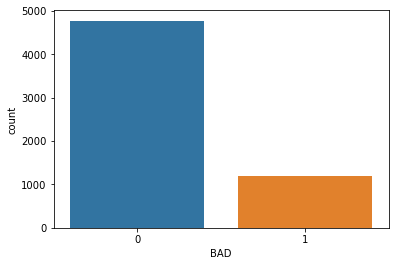

In [16]:
sns.countplot(x="BAD", data=abt)

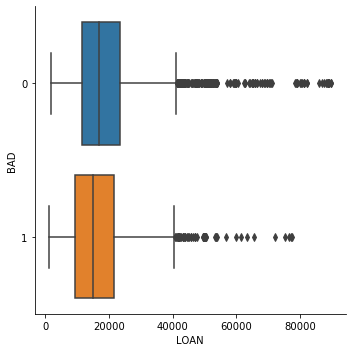

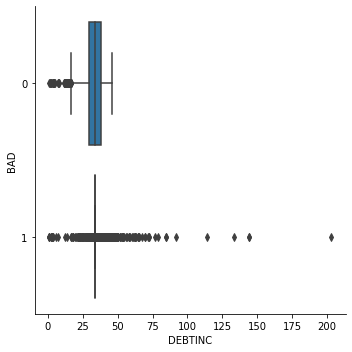

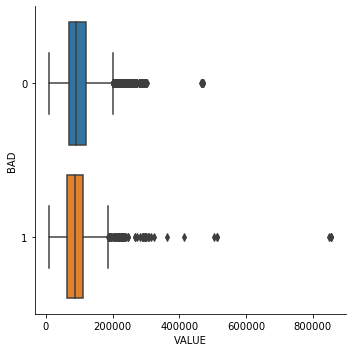

In [17]:
sns.catplot(x="LOAN", y="BAD", kind="box", data=abt);
sns.catplot(x="DEBTINC", y="BAD", kind="box", data=abt);
sns.catplot(x="VALUE", y="BAD", kind="box", data=abt);

In [18]:
corr = df.corr()
corr.style.background_gradient(cmap='Paired')

,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
LOAN,1,0.228595,0.335393,0.105728,-0.00130163,-0.0351445,0.0885396,0.0444875,0.0726312,0.0847347
MORTDUE,0.228595,1,0.875666,-0.0884803,-0.049516,-0.00104428,0.140047,0.031392,0.323631,0.154939
VALUE,0.335393,0.875666,1,0.00775852,-0.0486893,-0.0141027,0.171238,-0.00439779,0.269149,0.132174
YOJ,0.105728,-0.0884803,0.00775852,1,-0.0658789,0.0381535,0.201718,-0.071627,0.0248385,-0.0558913
DEROG,-0.00130163,-0.049516,-0.0486893,-0.0658789,1,0.211832,-0.0830473,0.173934,0.0618837,0.0170652
DELINQ,-0.0351445,-0.00104428,-0.0141027,0.0381535,0.211832,1,0.0224884,0.0678124,0.164639,0.0523645
CLAGE,0.0885396,0.140047,0.171238,0.201718,-0.0830473,0.0224884,1,-0.116935,0.237987,-0.0464767
NINQ,0.0444875,0.031392,-0.00439779,-0.071627,0.173934,0.0678124,-0.116935,1,0.0883887,0.141344
CLNO,0.0726312,0.323631,0.269149,0.0248385,0.0618837,0.164639,0.237987,0.0883887,1,0.185539
DEBTINC,0.0847347,0.154939,0.132174,-0.0558913,0.0170652,0.0523645,-0.0464767,0.141344,0.185539,1


## Model Development

In [19]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(abt[abt.columns.difference(target)], 
                                                                    abt[target], 
                                                                    test_size=0.33, random_state=27513)

## Look at traditional models...

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

classifiers = [
    LogisticRegression(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    GradientBoostingClassifier()
    ]

labels = ['Logit', 'DTree', 'RFor', 'GBoost']

In [21]:
models = []
models_dic = {}

for label, classifier in zip(labels, classifiers):
    model = classifier.fit(X_train, y_train.values.ravel())
    models_dic = {'label': label, 'model': model}
    models.append(models_dic)

pprint.pprint(models)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[{'label': 'Logit',
  'model': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)},
 {'label': 'DTree',
  'model': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')},
 {'label': 'RFor',
  'model': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                 

In [22]:
print('Misclassification Rates')
for m in models:
    dt_misclassification = 1 - metrics.accuracy_score(y_test, m['model'].predict(X_test))
    print('{} :'.format(m['label']), dt_misclassification)

Misclassification Rates
Logit : 0.19166243009659378
DTree : 0.13523131672597866
RFor : 0.08032536858159633
GBoost : 0.08896797153024916


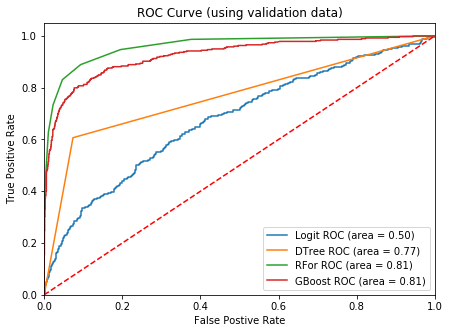

In [23]:
plt.figure(figsize = (7, 5))
for m in models:
    model = m['model']
    fpr, tpr, thresholds = metrics.roc_curve(y_test, model.predict_proba(X_test)[:,1])
    auc = metrics.roc_auc_score(y_test,model.predict(X_test))
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], auc))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Postive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (using validation data)')
plt.legend(loc="lower right")
plt.show()

In [24]:
del_models = ['Logit', 'DTree']        
models = [model_dict for model_dict in models if model_dict['label'] not in del_models]

## Challenge them with Xgboost...

In [25]:
%%time

xgb = XGBClassifier(max_depth=4,
                        subsample=0.9,
                        objective='binary:logistic',
                        n_estimators=100,
                        learning_rate = 0.1)
eval_set = [(X_train, y_train), (X_test, y_test)]
xgb.fit(X_train, y_train.values.ravel(), early_stopping_rounds=10,
          eval_metric=["error", "logloss"], eval_set=eval_set, verbose=True)

/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[0]	validation_0-error:0.133984	validation_0-logloss:0.633211	validation_1-error:0.139298	validation_1-logloss:0.63305
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 10 rounds.
[1]	validation_0-error:0.118708	validation_0-logloss:0.58305	validation_1-error:0.122522	validation_1-logloss:0.583244
[2]	validation_0-error:0.118207	validation_0-logloss:0.542093	validation_1-error:0.121505	validation_1-logloss:0.542065
[3]	validation_0-error:0.121963	validation_0-logloss:0.512	validation_1-error:0.110829	validation_1-logloss:0.511799
[4]	validation_0-error:0.121463	validation_0-logloss:0.481923	validation_1-error:0.108795	validation_1-logloss:0.481992
[5]	validation_0-error:0.112948	validation_0-logloss:0.455462	validation_1-error:0.107778	validation_1-logloss:0.455882
[6]	validation_0-error:0.113449	validation_0-logloss:0.433079	validation_1-error:0.107778	validation_1-logloss:0.433626


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.9, verbosity=1)

In [26]:
dt_misclassification = 1 - metrics.accuracy_score(y_test, xgb.predict(X_test))
print('Misclassification Rates\n', 'XGBoost :', dt_misclassification)

Misclassification Rates
 XGBoost : 0.08388408744280629


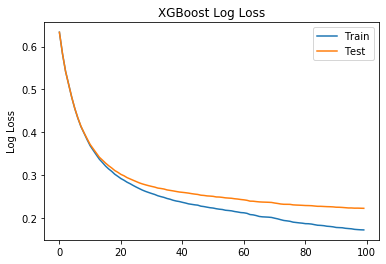

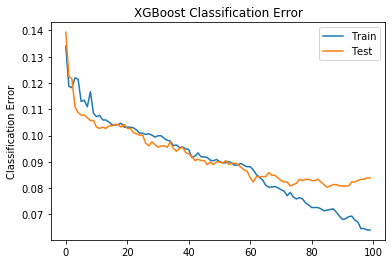

In [27]:
# retrieve performance metrics
results = xgb.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()
# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()


In [28]:
models.append({'label': 'XGBoost','model': xgb})

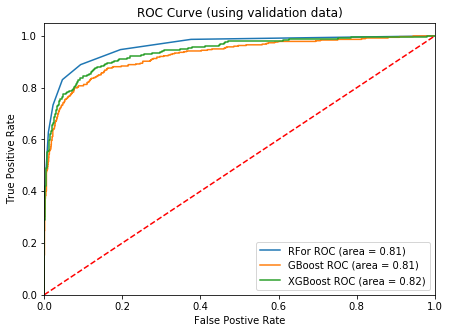

In [29]:
plt.figure(figsize = (7, 5))
for m in models:
    model = m['model']
    fpr, tpr, thresholds = metrics.roc_curve(y_test, model.predict_proba(X_test)[:,1])
    auc = metrics.roc_auc_score(y_test,model.predict(X_test))
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], auc))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Postive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (using validation data)')
plt.legend(loc="lower right")
plt.show()

#### The champion model is XgBoost. A possible challenger is Random Forest. Let's look at features importances...

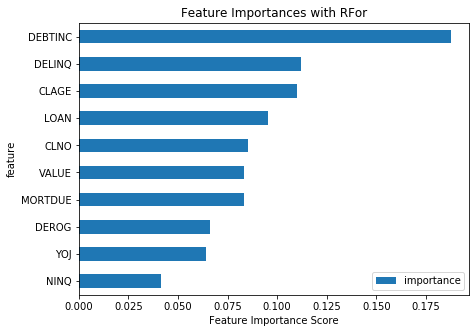

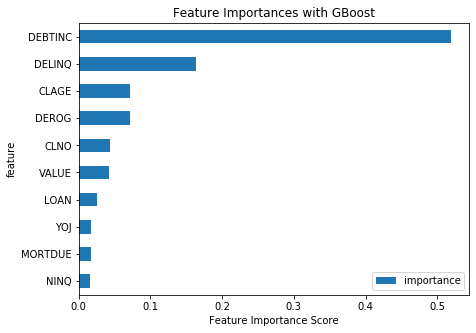

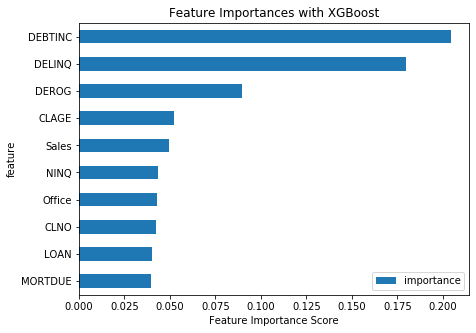

In [30]:
for m in models:
    model = m['model']
    feat_imp = pd.DataFrame({'importance':model.feature_importances_})
    feat_imp['feature'] = X_train.columns
    feat_imp.sort_values(by='importance', ascending=False, inplace=True)
    feat_imp = feat_imp.iloc[:10]

    feat_imp.sort_values(by='importance', inplace=True)
    feat_imp = feat_imp.set_index('feature', drop=True)
    feat_imp.plot.barh(title='Feature Importances with {}'.format(m['label']), figsize=(7, 5))
    plt.xlabel('Feature Importance Score')
    plt.show()

## Machine Learning Engineering

### Create ML pipelines for Random Forest (Challenger) and XgBoost (Champion)

Notice: During the Machine Learning Enginnering be sure to simulate the production enviroment!

# Rfor pipeline

In [31]:
class_inputs = list(df.select_dtypes('object').columns)
numerical_inputs = list(df.select_dtypes(include=['int64', 'float32']).columns)

# Preprocessing interval variables
numeric_transformer = Pipeline(steps=[
    
    ('numerical_imputer', SimpleImputer(strategy='median'))
])

# Preprocessing categorical variables
categorical_transformer = Pipeline(steps=[
    
    ('categorical_imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
    
])

# Create preprocessing step
preprocessor = ColumnTransformer(transformers=[
    
    ('numericals', numeric_transformer, numerical_inputs),
    ('categoricals', categorical_transformer, class_inputs)

])

rfor_pipeline = Pipeline(steps=[
    
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier())

])

## XGBoost pipeline

In [32]:
class_inputs = list(df.select_dtypes('object').columns)
numerical_inputs = list(df.select_dtypes(include=['int64', 'float32']).columns)

# Preprocessing interval variables
numeric_transformer = Pipeline(steps=[
    
    ('numerical_imputer', SimpleImputer(strategy='median'))
])

# Preprocessing categorical variables
categorical_transformer = Pipeline(steps=[
    
    ('categorical_imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
    
])

# Create preprocessing step
preprocessor = ColumnTransformer(transformers=[
    
    ('numericals', numeric_transformer, numerical_inputs),
    ('categoricals', categorical_transformer, class_inputs)

])

xgb_pipeline = Pipeline(steps=[
    
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier())

])

## Let's test ML Pipelines...

In [33]:
# mask = df.columns != 'BAD'
# target = 'BAD'

# Prod_X_train, Prod_X_test, Prod_y_train, Prod_y_test = model_selection.train_test_split(df.loc[:, mask], 
#                                                                     df.loc[:, target], 
#                                                                     test_size=0.33, random_state=27513)

Prod_X_train, Prod_X_test, Prod_y_train, Prod_y_test = model_selection.train_test_split(df[df.columns.difference(target)], 
                                                                    df[target], 
                                                                    test_size=0.33, random_state=27513)

In [34]:
rfor_pipeline.fit(Prod_X_train, Prod_y_train)
Prod_y_predict=rfor_pipeline.predict_proba(Prod_X_test)
# Prod_y_predict=rfor_pipeline.predict(Prod_X_test)
Prod_y_predict

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


array([[0.5, 0.5],
       [0.9, 0.1],
       [0.5, 0.5],
       ...,
       [1. , 0. ],
       [1. , 0. ],
       [1. , 0. ]])

In [35]:
rfor_pipeline.score(Prod_X_test, Prod_y_test)

0.9262836807320793

In [36]:
xgb_pipeline.fit(Prod_X_train, Prod_y_train)
Prod_y_predict=xgb_pipeline.predict_proba(Prod_X_test)
Prod_y_predict

/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([[0.36639297, 0.63360703],
       [0.9428655 , 0.05713449],
       [0.4142139 , 0.5857861 ],
       ...,
       [0.98149425, 0.01850577],
       [0.9753905 , 0.0246095 ],
       [0.92528284, 0.07471715]], dtype=float32)

In [37]:
xgb_pipeline.score(Prod_X_test, Prod_y_test)

0.9110320284697508

# Model Governance and Model Deployment with SAS Model Manager

For Model Deployment purpose, we need some files:

- Required

    0. requirement.json
    1. score.py
    2. model.pkl
    3. inputVar.json
    4. outputVar.json
    
    
- Optional
    
    5. train.py
    6. fileMetadata.json
    7. ModelProperties.json
    8. dmcas_fitstat.json
    9. dmcas_roc
    10. dmcas_lift


In [38]:
from viyapy.services import utils

In [39]:
import zipfile

def zipdir(src, dst): #take source code file and choose a destination
    zf = zipfile.ZipFile('%s' % (dst), "w", zipfile.ZIP_DEFLATED) #Open zip file
    abs_src = os.path.abspath(src) 
    for dirname, subdirs, files in os.walk(src): #generate the directory tree
        for filename in files:
            absname = os.path.abspath(os.path.join(dirname, filename)) 
            arcname = absname[len(abs_src) + 1:]
            print ("zipping %s as %s" % (os.path.join(dirname, filename),arcname))
            zf.write(absname, arcname),
    zf.close()

In [40]:
! mkdir -p models_packages

In [41]:
! mkdir -p ./experiment_rfor ./experiment_xgboost

## 0. requirement.json

In [42]:
%%writefile ./experiment_xgboost/requirements.json

[   
    {
        "step":"install scikit-learn==0.21.3 ",
        "command":"pip install -U scikit-learn==0.21.3"
     },
    {
        "step":"install xgboost ",
        "command":"pip install xgboost==0.90"
     },
    {
        "step":"install joblib ",
        "command":"pip install joblib"
     }
]

Overwriting ./experiment_xgboost/requirements.json


In [43]:
%%writefile ./experiment_rfor/requirements.json

[   
    {
        "step":"install scikit-learn==0.21.3 ",
        "command":"pip install -U scikit-learn==0.21.3"
     },
    {
        "step":"install joblib ",
        "command":"pip install joblib"
     }
]

Overwriting ./experiment_rfor/requirements.json


## 1. Score.py 

About the Score code, SAS Model Manager does not generate Container Wrapper automatically. Then I use the Scoring format provided by Github folder

In [44]:
%%writefile ./experiment_rfor/score.py

# If the pickle file has not specified in command-line arguments, the script
# looks for the first pickle file in the current directory, and the script quits, if the file is not found.

# The scoring script reads the input variables from the inputVar.json file, and the output variables
# from the outputVar.json file.

# The scoring script reads the input data from input CSV file and stores the output data in the CSV file.

import argparse
import os
import os.path
import sys
import pandas as pd
import joblib
import json

# Find the first file that matches the pattern.


def find_file(suffix):
    current_dir = os.path.dirname(os.path.abspath(__file__))
    for file in os.listdir(current_dir):
        if file.endswith(suffix):
            filename = file
            return os.path.join(current_dir, filename)

    return None


def load_var_names(filename):
    var_file = find_file(filename)
    if var_file is None:
        return None
    if os.path.isfile(var_file):
        with open(var_file) as f:
            json_object = json.load(f)

        names = []
        for row in json_object:
            names.append(row["name"])
        return names
    else:
        print('Didnot find file: ', filename)
        return None


def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3


def load_data_by_input_vars(data):
    names = load_var_names('inputVar.json')
    if names is None:
        return data
    else:
        newcolumns = intersection(list(data.columns), names)
        return data[newcolumns]


def run(model_file, input_file, output_file):

    if model_file is None:
        print('Not found Python pickle file!')
        sys.exit()

    if not os.path.isfile(input_file):
        print('Not found input file', input_file)
        sys.exit()

    inputDf = pd.read_csv(input_file).fillna(0)

    output_vars = load_var_names('outputVar.json')

    in_dataf = load_data_by_input_vars(inputDf)

    model = open(model_file, 'rb')
    rfor = joblib.load(model)
    model.close()

    outputDf = pd.DataFrame(rfor.predict_proba(in_dataf))

    if output_vars is None:
        outputcols = map(lambda x: 'P_' + str(x), list(rfor.classes_))
    else:
        outputcols = map(lambda x: output_vars[x], list(rfor.classes_))
    outputDf.columns = outputcols

    # merge with input data
    outputDf = pd.merge(inputDf, outputDf, how='inner',
                        left_index=True, right_index=True)

    print('printing first few lines...')
    print(outputDf.head())
    outputDf.to_csv(output_file, sep=',', index=False)
    return outputDf.to_dict()


def main():
    # parse arguments
    parser = argparse.ArgumentParser(description='Score')
    parser.add_argument('-m', dest="modelFile",
                        help='model file name, the default is the first PKL file that is found in the directory')
    parser.add_argument('-i', dest="scoreInputCSV",
                        required=True, help='input filename')
    parser.add_argument('-o', dest="scoreOutputCSV",
                        required=True, help='output csv filename')

    args = parser.parse_args()
    model_file = args.modelFile
    input_file = args.scoreInputCSV
    output_file = args.scoreOutputCSV

    # Search for the first PKL file in the directory if argument is not specified.
    if model_file is None:
        for file in os.listdir("."):
            if file.endswith(".pickle"):
                model_file = file
                break

    result = run(model_file, input_file, output_file)
    return 0


if __name__ == "__main__":
    sys.exit(main())

Overwriting ./experiment_rfor/score.py


In [45]:
%%writefile ./experiment_xgboost/score.py

# If the pickle file has not specified in command-line arguments, the script
# looks for the first pickle file in the current directory, and the script quits, if the file is not found.

# The scoring script reads the input variables from the inputVar.json file, and the output variables
# from the outputVar.json file.

# The scoring script reads the input data from input CSV file and stores the output data in the CSV file.

import argparse
import os
import os.path
import sys
import pandas as pd
import joblib
import json

# Find the first file that matches the pattern.


def find_file(suffix):
    current_dir = os.path.dirname(os.path.abspath(__file__))
    for file in os.listdir(current_dir):
        if file.endswith(suffix):
            filename = file
            return os.path.join(current_dir, filename)

    return None


def load_var_names(filename):
    var_file = find_file(filename)
    if var_file is None:
        return None
    if os.path.isfile(var_file):
        with open(var_file) as f:
            json_object = json.load(f)

        names = []
        for row in json_object:
            names.append(row["name"])
        return names
    else:
        print('Didnot find file: ', filename)
        return None


def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3


def load_data_by_input_vars(data):
    names = load_var_names('inputVar.json')
    if names is None:
        return data
    else:
        newcolumns = intersection(list(data.columns), names)
        return data[newcolumns]


def run(model_file, input_file, output_file):

    if model_file is None:
        print('Not found Python pickle file!')
        sys.exit()

    if not os.path.isfile(input_file):
        print('Not found input file', input_file)
        sys.exit()

    inputDf = pd.read_csv(input_file).fillna(0)

    output_vars = load_var_names('outputVar.json')

    in_dataf = load_data_by_input_vars(inputDf)

    model = open(model_file, 'rb')
    xgboost = joblib.load(model)
    model.close()

    outputDf = pd.DataFrame(xgboost.predict_proba(in_dataf))

    if output_vars is None:
        outputcols = map(lambda x: 'P_' + str(x), list(xgboost.classes_))
    else:
        outputcols = map(lambda x: output_vars[x], list(xgboost.classes_))
    outputDf.columns = outputcols

    # merge with input data
    outputDf = pd.merge(inputDf, outputDf, how='inner',
                        left_index=True, right_index=True)

    print('printing first few lines...')
    print(outputDf.head())
    outputDf.to_csv(output_file, sep=',', index=False)
    return outputDf.to_dict()


def main():
    # parse arguments
    parser = argparse.ArgumentParser(description='Score')
    parser.add_argument('-m', dest="modelFile",
                        help='model file name, the default is the first PKL file that is found in the directory')
    parser.add_argument('-i', dest="scoreInputCSV",
                        required=True, help='input filename')
    parser.add_argument('-o', dest="scoreOutputCSV",
                        required=True, help='output csv filename')

    args = parser.parse_args()
    model_file = args.modelFile
    input_file = args.scoreInputCSV
    output_file = args.scoreOutputCSV

    # Search for the first PKL file in the directory if argument is not specified.
    if model_file is None:
        for file in os.listdir("."):
            if file.endswith(".pickle"):
                model_file = file
                break

    result = run(model_file, input_file, output_file)
    return 0


if __name__ == "__main__":
    sys.exit(main())

Overwriting ./experiment_xgboost/score.py


## 2. model.pickle

In [46]:
from sklearn.externals import joblib
folders = ['experiment_rfor', 'experiment_xgboost']
pipes = [rfor_pipeline, xgb_pipeline]
pickles = ['rfor_pipeline.pickle', 'xgb_pipeline.pickle']

for folder, pipe, pkl in zip(folders, pipes, pickles):
    joblib.dump(pipe, './{}/{}'.format(folder, pkl))

/opt/conda/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


## 3. ModelProperties

In [47]:
# for folder in folders: 
utils.generate_modelproperties('experiment_xgboost', 'xgboost for hmeq', 'bad', 'forest', 1, 2, 'ivnard', 'experiment_xgboost')
utils.generate_modelproperties('experiment_rfor', 'random forest for hmeq', 'bad', 'forest', 1, 2, 'ivnard', 'experiment_rfor')

## 4. inputVar

In [48]:
for folder in folders: 
    utils.generate_inputvar(df, 'BAD', './{}'.format(folder), debug=False)


## 5. outputVar

In [49]:
 for folder in folders: 
    utils.generate_outputvar(df, 'BAD', './{}'.format(folder), debug=False)

## 6.Train.py

In [50]:
%%writefile ./experiment_rfor/train.py

# Import Libraries #

# Mongo Library

import pymongo

# ML libraries

import numpy as np
import pandas as pd

from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
import sklearn.model_selection as model_selection
from sklearn.ensemble import RandomForestClassifier

# Tool libraries
import joblib

# Connect to mongodb container #

conn = pymongo.MongoClient('mongo', 27017)

# Read data #

db = conn.training
collection = db.churn_data
df = pd.DataFrame(list(collection.find()))
df.drop('_id', axis=1, inplace=True)
df.drop_duplicates(inplace=True)

# Prepare Data #

cols = df[df.columns.difference(['BAD', 'LOAN', 'REASON', 'JOB'])].columns
df[cols] = df[cols].apply(pd.to_numeric, downcast='float', errors='coerce')
df['BAD'] = df['BAD'].astype('category')

# Declare Variables #

# target var
target = df.select_dtypes('category').columns
# categorical (nominal and ordinal) variables
class_inputs = list(df.select_dtypes('object').columns)
# input interval variables
numerical_inputs = list(df.select_dtypes(include=['int64', 'float32']).columns)
inputs = class_inputs + numerical_inputs

# Data engineering #

# Impute missings

categorical_imputer = SimpleImputer(
    missing_values='', strategy='most_frequent')
numerical_imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

# Impute categorical variables

categorical_imputer.fit(df[class_inputs])
categorical_imputed = categorical_imputer.transform(df[class_inputs])
df_categorical_imputed = pd.DataFrame(
    data=categorical_imputed, columns=class_inputs)

# Impute numerical variables

numerical_imputer.fit(df[numerical_inputs])
numerical_imputed = numerical_imputer.transform(df[numerical_inputs])
df_numerical_imputed = pd.DataFrame(
    data=numerical_imputed, columns=numerical_inputs)

# One-hot encoding

encoder = OneHotEncoder()
encoder.fit(categorical_imputed)
categorical_encoded = encoder.transform(categorical_imputed)

categories = list(np.hstack(encoder.categories_, ))
df_categorical_encoded = pd.DataFrame(
    data=categorical_encoded.toarray(), columns=categories)

# ABT

abt = pd.concat([df[target], df_numerical_imputed,
                 df_categorical_encoded], axis=1)


# Model Training #

X_train, X_test, y_train, y_test = model_selection.train_test_split(abt[abt.columns.difference(target)],
                                                                    abt[target],
                                                                    test_size=0.33, random_state=27513)

# Build Sklearn Random Forest
rfor = RandomForestClassifier()
rfor.fit(X_train, y_train)

output = open('./experiment_rfor/rfor.pickle', 'wb')
joblib.dump(rfor, output)
output.close()

Overwriting ./experiment_rfor/train.py


In [51]:
%%writefile ./experiment_xgboost/train.py

# Import Libraries #

# Mongo Library

import pymongo

# ML libraries

import numpy as np
import pandas as pd

from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
import sklearn.model_selection as model_selection
from xgboost import XGBClassifier 

# Tool libraries
import joblib

# Connect to mongodb container #

conn = pymongo.MongoClient('mongo', 27017)

# Read data #

db = conn.training
collection = db.churn_data
df = pd.DataFrame(list(collection.find()))
df.drop('_id', axis=1, inplace=True)
df.drop_duplicates(inplace=True)

# Prepare Data #

cols = df[df.columns.difference(['BAD', 'LOAN', 'REASON', 'JOB'])].columns
df[cols] = df[cols].apply(pd.to_numeric, downcast='float', errors='coerce')
df['BAD'] = df['BAD'].astype('category')

# Declare Variables #

# target var
target = df.select_dtypes('category').columns
# categorical (nominal and ordinal) variables
class_inputs = list(df.select_dtypes('object').columns)
# input interval variables
numerical_inputs = list(df.select_dtypes(include=['int64', 'float32']).columns)
inputs = class_inputs + numerical_inputs

# Data engineering #

# Impute missings

categorical_imputer = SimpleImputer(
    missing_values='', strategy='most_frequent')
numerical_imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

# Impute categorical variables

categorical_imputer.fit(df[class_inputs])
categorical_imputed = categorical_imputer.transform(df[class_inputs])
df_categorical_imputed = pd.DataFrame(
    data=categorical_imputed, columns=class_inputs)

# Impute numerical variables

numerical_imputer.fit(df[numerical_inputs])
numerical_imputed = numerical_imputer.transform(df[numerical_inputs])
df_numerical_imputed = pd.DataFrame(
    data=numerical_imputed, columns=numerical_inputs)

# One-hot encoding

encoder = OneHotEncoder()
encoder.fit(categorical_imputed)
categorical_encoded = encoder.transform(categorical_imputed)

categories = list(np.hstack(encoder.categories_, ))
df_categorical_encoded = pd.DataFrame(
    data=categorical_encoded.toarray(), columns=categories)

# ABT

abt = pd.concat([df[target], df_numerical_imputed,
                 df_categorical_encoded], axis=1)


# Model Training #

X_train, X_test, y_train, y_test = model_selection.train_test_split(abt[abt.columns.difference(target)],
                                                                    abt[target],
                                                                    test_size=0.33, random_state=27513)

# Build Sklearn Random Forest
xgb = XGBClassifier(max_depth=4,
                        subsample=0.9,
                        objective='binary:logistic',
                        n_estimators=100,
                        learning_rate = 0.1)
eval_set = [(X_train, y_train), (X_test, y_test)]
xgb.fit(X_train, y_train.values.ravel(), early_stopping_rounds=10,
          eval_metric=["error", "logloss"], eval_set=eval_set, verbose=True)

output = open('./experiment_xgboost/xgboost.pickle', 'wb')
joblib.dump(xgb, output)
output.close()

Overwriting ./experiment_xgboost/train.py


## 6. dmcas_lift

In [52]:
for folder, pipe in zip(folders, pipes):
    utils.generate_lift(Prod_y_train, Prod_y_test, 'BAD', 1, pipe.predict_proba(Prod_X_train)[:,1], pipe.predict_proba(Prod_X_test)[:,1], folder, debug=False)

## 7. dmcas_roc

In [53]:
for folder, pipe in zip(folders, pipes):
    utils.generate_roc(Prod_y_train, Prod_y_test, 'BAD', 1, pipe.predict_proba(Prod_X_train)[:,1], pipe.predict_proba(Prod_X_test)[:,1], folder, debug=False)

## 8. dmcas_fitstat

In [54]:
for folder, pipe in zip(folders, pipes):
    utils.generate_fitstat(Prod_y_train, Prod_y_test, 'BAD', 1, pipe.predict_proba(Prod_X_train)[:,1], pipe.predict_proba(Prod_X_test)[:,1], folder, debug=False)

## 9. fileMetadata

In [55]:
for folder, pickle in zip(folders, pickles):
    utils.generate_fileMetadata('score.py', pickle, folder)

## Create the Model Package 

In [56]:
sourceDir = './experiment_xgboost'
modelZipfile = 'experiment_xgboost' + ".zip"
zipdir(sourceDir, modelZipfile)

zipping ./experiment_xgboost/dmcas_fitstat.json as dmcas_fitstat.json
zipping ./experiment_xgboost/dmcas_lift.json as dmcas_lift.json
zipping ./experiment_xgboost/dmcas_roc.json as dmcas_roc.json
zipping ./experiment_xgboost/fileMetadata.json as fileMetadata.json
zipping ./experiment_xgboost/inputVar.json as inputVar.json
zipping ./experiment_xgboost/modelproperties.json as modelproperties.json
zipping ./experiment_xgboost/outputVar.json as outputVar.json
zipping ./experiment_xgboost/requirements.json as requirements.json
zipping ./experiment_xgboost/score.py as score.py
zipping ./experiment_xgboost/train.py as train.py
zipping ./experiment_xgboost/xgb_pipeline.pickle as xgb_pipeline.pickle


In [57]:
sourceDir = './experiment_rfor'
modelZipfile = 'experiment_rfor' + ".zip"
zipdir(sourceDir, modelZipfile)

zipping ./experiment_rfor/dmcas_fitstat.json as dmcas_fitstat.json
zipping ./experiment_rfor/dmcas_lift.json as dmcas_lift.json
zipping ./experiment_rfor/dmcas_roc.json as dmcas_roc.json
zipping ./experiment_rfor/fileMetadata.json as fileMetadata.json
zipping ./experiment_rfor/inputVar.json as inputVar.json
zipping ./experiment_rfor/modelproperties.json as modelproperties.json
zipping ./experiment_rfor/outputVar.json as outputVar.json
zipping ./experiment_rfor/requirements.json as requirements.json
zipping ./experiment_rfor/rfor_pipeline.pickle as rfor_pipeline.pickle
zipping ./experiment_rfor/score.py as score.py
zipping ./experiment_rfor/train.py as train.py


In [58]:
! mkdir -p ./models_packages/champion
! mkdir -p ./models_packages/challenger

In [59]:
! mv "./experiment_rfor.zip" "./models_packages/champion"
! mv "./experiment_xgboost.zip" "./models_packages/challenger"